In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from pymongo import MongoClient

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

import re

# Import from MongoDB

In [25]:
config = {
  'host': '52.14.212.41:27017',
  'username': 'mongo_user',
  'password': 'password',
  'authSource': 'books'
}

client = MongoClient(**config)

db = client.books

In [26]:
db.collection_names()

/Users/hdeva/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: collection_names is deprecated. Use list_collection_names instead.
  """Entry point for launching an IPython kernel.


['books']

In [27]:
db['books'].count()

/Users/hdeva/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  """Entry point for launching an IPython kernel.


3105520

In [28]:
doc=db.books.find_one()
print(doc)

{'_id': ObjectId('5d4ca786c986ed4ecbd7e1a0'), 'marketplace': 'US', 'customer_id': 12076615, 'review_id': 'RQ58W7SMO911M', 'product_id': 385730586, 'product_parent': 122662979, 'product_title': 'Sisterhood of the Traveling Pants (Book 1)', 'product_category': 'Books', 'star_rating': 4, 'helpful_votes': 2, 'total_votes': 3, 'vine': 'N', 'verified_purchase': 'N', 'review_headline': 'this book was a great learning novel!', 'review_body': 'this boook was a great one that you could learn from. it not only teaches the imponrtance of family and their values but it also deals with basic issues that teens and some kids even deal with.  this book is about 4 best friends who are for the first time in their lives spending their summer apart. one day they are all in one of the girls rooms and finds a pair of pants that were tucked away in her closet.  once all four  of them try them on they realize that there is really something special about these pants.  seeming as how all 4 girls are differnt sha

In [62]:
doc = db.books.aggregate([
    { '$match' : {'helpful_votes': {'$gte': 2} } },
    { '$match' : {'star_rating': {'$ne': 3} } },
    { '$project': { 
        '_id': 1,
        'product_title': 1,
        'review_body': 1,
        'review_date': 1,
        'review_headline': 1,
        'star_rating': 1,
        'votes_ratio': { 
            '$cond': [
                { '$eq': [ "$total_votes", 0 ] },
                0,
                { '$divide': [ "$helpful_votes", "$total_votes" ] }
            ]
        },
        'sentiment': { 
            '$cond': [
                { '$gt': [ "$star_rating", 3 ] },
                'positive',
                'negative'
            ]
        } 
    } },
    { '$match' : {'votes_ratio': {'$gte': 0.5} } }
]
)
books_df = pd.DataFrame(list(doc))
books_df.shape

(1856207, 8)

In [65]:
with open('book_reviews_data.pickle', 'wb') as to_write:
    pickle.dump(books_df, to_write)

# Exploratory Data Analysis

In [7]:
with open('book_reviews_data.pickle','rb') as read_file:
    books_df = pickle.load(read_file)

In [3]:
books_df.shape

(1856207, 8)

In [4]:
books_df.head(5)

,_id,product_title,review_body,review_date,review_headline,sentiment,star_rating,votes_ratio
0,5d4ca786c986ed4ecbd7e1a0,Sisterhood of the Traveling Pants (Book 1),this boook was a great one that you could lear...,2005-10-14,this book was a great learning novel!,positive,4,0.666667
1,5d4ca786c986ed4ecbd7e1a3,Colby Conspiracy (Colby Agency),Though she is honored to be Chicago Woman of t...,2005-10-14,fine author on her A-game,positive,5,1.000000
2,5d4ca786c986ed4ecbd7e1a5,The Catcher in the Rye,My only complaint is that this book was a bit ...,2005-10-14,"Interesting, fun.",positive,4,1.000000
3,5d4ca786c986ed4ecbd7e1a6,Bait and Switch: The (Futile) Pursuit of the A...,"This book is chilling and depressing indeed, t...",2005-10-14,I viewed this the opposite of Publisher's Week...,positive,4,0.818182
4,5d4ca786c986ed4ecbd7e1a8,A Little History of the World (Little Histories),"Never been much for enjoying history, but the ...",2005-10-14,"Simple, entertaining!",positive,5,0.800000


In [5]:
books_df['review_body'] = books_df['review_body'].apply(str)
books_df['review_headline'] = books_df['review_headline'].apply(str)

In [6]:
books_df['year'] = pd.DatetimeIndex(books_df['review_date']).year
books_df['year'].value_counts()

2000    341684
2004    270821
2001    268567
2003    255108
2002    251885
2005    251500
1999    137806
1998     58761
1997     17605
1996      2370
1995       100
Name: year, dtype: int64

In [7]:
len(books_df['product_title'].unique())

540686

In [8]:
books_df = books_df.drop('review_date', axis=1)
books_df.head(5)

,_id,product_title,review_body,review_headline,sentiment,star_rating,votes_ratio,year
0,5d4ca786c986ed4ecbd7e1a0,Sisterhood of the Traveling Pants (Book 1),this boook was a great one that you could lear...,this book was a great learning novel!,positive,4,0.666667,2005
1,5d4ca786c986ed4ecbd7e1a3,Colby Conspiracy (Colby Agency),Though she is honored to be Chicago Woman of t...,fine author on her A-game,positive,5,1.000000,2005
2,5d4ca786c986ed4ecbd7e1a5,The Catcher in the Rye,My only complaint is that this book was a bit ...,"Interesting, fun.",positive,4,1.000000,2005
3,5d4ca786c986ed4ecbd7e1a6,Bait and Switch: The (Futile) Pursuit of the A...,"This book is chilling and depressing indeed, t...",I viewed this the opposite of Publisher's Week...,positive,4,0.818182,2005
4,5d4ca786c986ed4ecbd7e1a8,A Little History of the World (Little Histories),"Never been much for enjoying history, but the ...","Simple, entertaining!",positive,5,0.800000,2005


In [9]:
books_df['sentiment'].value_counts()

positive    1634589
negative     221618
Name: sentiment, dtype: int64

In [10]:
books_df['star_rating'].value_counts()

5    1259673
4     374916
1     122412
2      99206
Name: star_rating, dtype: int64

Huge class imbalance.

# Text Preprocessing

In [7]:
import spacy
from nltk.corpus import stopwords
import nltk
from string import punctuation

from autocorrect import spell

import enchant

spacy_nlp = spacy.load('en')
english_words = enchant.Dict("en_US")

stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ["br", "non", "book","time","story", "novel", "resource", "great", "good", 
                "way", "thing", "new", "author", 
                "page", "plot", "read", "reader", "review", "lot", "little", "main",
                "find", "write", "year", "know", "come", "want", "day", "take",
                "bring", "think", "get", "like", "try", "word", "understand",
                "say", "look", "need", "buy", "use", "text", "help", "chapter", "amp", "mean", 
                "make", "learning", "bit", "subplot", "life", "work", "extra", "alex", ]

stopwords.extend(newStopWords)

#Check for fake reviews
stopwords.remove('i')
stopwords.remove('me')
stopwords.remove('my')
stopwords.remove('myself')

In [8]:
def get_key_words(row_headline, row_body):

    row_headline = row_headline.replace("\\","")
    row_body = row_body.replace("\\","")
    row_headline = row_headline.replace("'"," ")
    row_body = row_body.replace("'"," ")
    row_body = row_body.replace("<br /><br />"," ")
    row_body = row_body.replace("<br />"," ")
    row_body = row_body.replace("&quot;"," ")

    
    doc = spacy_nlp(row_headline + ' ' + row_body)
    list_of_words = []

    for token in doc:
        if (token.pos_ == 'NOUN' or token.pos_ == 'ADJ' or token.pos_ == 'VERB' or token.pos_ == 'ADV') and token.is_stop == False:
        #if (token.pos_ == 'NOUN') and token.is_stop == False:
            if bool(re.search(r'\d', token.lemma_)) == False:
                list_of_words.append(token.lemma_)
    
    #Remove misspellings
    list_of_words = [word.lower() for word in list_of_words if english_words.check(word)]
    
    for ent in doc.ents:
        if ent.label_ == 'ORG' or ent.label_ == 'PRODUCT' or ent.label_ == 'GPE' or ent.label_ == 'NORP':
            if bool(re.search(r'\d', ent.lemma_)) == False:
                list_of_words.append(ent.lemma_)
    
    # Remove stop words and words less than 3 characters
    list_of_words = [word for word in list_of_words if len(word) > 2]
    list_of_words = [word for word in list_of_words if word not in stopwords]
    
    return list_of_words

In [11]:
def get_keywords_column(df):
    df['keywords'] = df.apply(lambda row: get_key_words(row['review_headline'], row['review_body']), axis=1)
    return df

In [78]:
' '.join(get_key_words(books_df.iloc[5]['review_headline'], books_df.iloc[5]['review_body']))

'face intentional audience current military member enjoy volume root trouble follow successfully show military personnel mixed feeling war address behavior midst battle interested view war hold outside war experience backward retrospect people feel midst madness certainly different anticipate adjust feeling flavor derive personal interview historical research approach negative stay scope knowledge expertise title flawed historian sociological credibility harshly critical reviewer expect highly technical depth psychological approach note cite state cent infantryman fire true subject woman military barely broach fairness pretend extensive knowledge woman react battle simply deficiency character feeling skim present interested peace study enjoy number passage shed light seek pro military characterize honest endeavor address difficult question concern death kill war american'

In [59]:
' '.join(get_key_words(books_df.iloc[0]['review_headline'], books_df.iloc[1]['review_body']))

'honor euphoric mental improvement son show recently especially fall love snatch ago turn kill goal murder abandon elation turn despair resurface start rape pregnant military strategist town complement hire father veteran homicide detective murder letter link dad woman long ago murder husband dad partner confuse soon meet embroil conspiracy decade ago confusing audience comprehend complex superb suspense thriller start tale agency bodyguard ensemble cast solid fan feel overcome tragedy hope defeat root wonder happen decade ago final twist mark strong deceit tale showcase fine game Chicago the Colby Agency Chicago Victoria colby Colby Agency FILES Victoria'

In [10]:
books_15000_review_2005_df = books_df_2005.head(15000)

In [12]:
books_15000_review_2005_df = get_keywords_column(books_15000_review_2005_df)
books_15000_review_2005_df.head(5)

/Users/hdeva/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,_id,product_title,review_body,review_date,review_headline,sentiment,star_rating,votes_ratio,year,keywords
0,5d4ca786c986ed4ecbd7e1a0,Sisterhood of the Traveling Pants (Book 1),this boook was a great one that you could lear...,2005-10-14,this book was a great learning novel!,positive,4,0.666667,2005,"[learn, teach, family, value, deal, basic, iss..."
1,5d4ca786c986ed4ecbd7e1a3,Colby Conspiracy (Colby Agency),Though she is honored to be Chicago Woman of t...,2005-10-14,fine author on her A-game,positive,5,1.000000,2005,"[fine, game, honor, euphoric, mental, improvem..."
2,5d4ca786c986ed4ecbd7e1a5,The Catcher in the Rye,My only complaint is that this book was a bit ...,2005-10-14,"Interesting, fun.",positive,4,1.000000,2005,"[interesting, fun, complaint, vocabulary, cons..."
3,5d4ca786c986ed4ecbd7e1a6,Bait and Switch: The (Futile) Pursuit of the A...,"This book is chilling and depressing indeed, t...",2005-10-14,I viewed this the opposite of Publisher's Week...,positive,4,0.818182,2005,"[view, opposite, chilling, depressing, sprinkl..."
4,5d4ca786c986ed4ecbd7e1a8,A Little History of the World (Little Histories),"Never been much for enjoying history, but the ...",2005-10-14,"Simple, entertaining!",positive,5,0.800000,2005,"[simple, entertain, enjoy, history, style, bre..."


In [13]:
with open('books_review_2005.pickle', 'wb') as to_write:
    pickle.dump(books_15000_review_2005_df, to_write)

# Word Vectorizers

In [2]:
with open('books_review_2005.pickle','rb') as read_file:
    books_review_2005_df = pickle.load(read_file)

In [90]:
def get_keywords_corpus(df):
    keywords = []
    for index, row in df.iterrows() :
        keywords.append(' '.join(row['keywords']))
    return keywords

In [92]:
tf_idf_2_gram_vectorizer_2005 = TfidfVectorizer(ngram_range=(1, 2), lowercase=True,  
                                   stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")

In [93]:
keywords_2005 = get_keywords_corpus(books_review_2005_df)
doc_word_tfidf_2_gram_2005 = tf_idf_2_gram_vectorizer_2005.fit_transform(keywords_2005)

# Algorithms / Topic Modeling

In [95]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

## NMF

In [97]:
nmf_tfidf_2_gram_2005 = NMF(30)
doc_topic_nmf_tfidf_2_gram_2005 = nmf_tfidf_2_gram_2005.fit_transform(doc_word_tfidf_2_gram_2005)
display_topics(nmf_tfidf_2_gram_2005, tf_idf_2_gram_vectorizer_2005.get_feature_names(), 30)


Topic  0
church, christian, catholic, science, idea, faith, study, theory, issue, human, point, world, truth, view, religion, present, modern, provide, philosophy, essay, scientific, spiritual, state, important, christians, religious, belief, argument, believe, understanding

Topic  1
love, love love, wait, fall love, romance, wonderful, fall, favorite, heart, love character, absolutely love, funny, feel, beautiful, daughter love, happy, absolutely, love favorite, love wait, laugh, true love, girl, lover, old love, true, wonderful love, sweet, romantic, thank, heroine

Topic  2
child, parent, adult, kid, young, young child, teach, age, child love, illustration, child child, child age, child adult, parent child, home, favorite child, baby, mother, teach child, raise, school, behavior, love child, childhood, parenting, animal, adult child, picture, grow, sleep

Topic  3
recipe, cookbook, cook, ingredient, cooking, dish, food, delicious, taste, soup, recipe easy, kitchen, favorite, bread

interesting, informative, reading, interesting recommend, interesting informative, insight, interesting interesting, subject, interested, enjoyable, definitely, character interesting, interesting idea, fun, easy interesting, fascinating, research, interesting job, writing, interesting easy, entertaining, particularly, expect, idea, finish, funny, interesting character, fact, idea forward, overall


In [98]:
books_review_2005_df.shape

(15000, 10)

In [99]:
H_2005 = pd.DataFrame(doc_topic_nmf_tfidf_2_gram_2005.round(3),
             index = books_review_2005_df['product_title'],
             columns = ["Religion", "Love", "Child/Young Adult", "Cooking", "Recommend", "Life and Death", "Good Storytelling", "American History", "Reference", "Relationships", "Series", "School Setting", "Informational", "Easy to Follow", "Education", "Travel", "Society", "Excellent", "Enjoy", "Empowerment", "Waste of Money", "Family", "Game", "Scene Setting Family Referrals", "Language", "Weight Loss", "Art", "Business", "Step by Step", "Interesting and Informative"])
H_2005.shape

(15000, 30)

In [100]:
with open('H_2005.pickle', 'wb') as to_write:
    pickle.dump(H_2005, to_write)

# Clustering

In [5]:
# helper function that allows us to display data in 2 dimensions an highlights the clusters
def display_cluster(X,km=[],num_clusters=0, title='PCA Analysis', legend=[]):
    colors_array = ["#ff9900", "#000000", "#146eb4", "#ff4500", "#f0e68c", "purple", "green"]
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = colors_array[i],alpha = alpha,s=s)
            #plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)
    plt.legend(legend) 
    plt.title(title, fontsize=14)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")

In [6]:
# helper function that allows us to display data in 3 dimensions an highlights the clusters
def display_cluster_3d(X,km=[],num_clusters=0, title='PCA Analysis', legend=[]):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d') 
    colors_array = ["#ff9900", "#000000", "#146eb4", "#ff4500", "#f0e68c", "purple", "green"]
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],X[:,2],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],X[km.labels_==i,2],c = colors_array[i])
            #plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)
    plt.legend(legend) 
    plt.title(title, fontsize=14)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.zlabel("PCA Component 3")

In [7]:
def plot_inertia_curve(data):
    # k means determine k
    inertia = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(data)
        inertia.append(kmeanModel.inertia_)
    # Plot the elbow
    plt.plot(K, inertia, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()


In [8]:
with open('H_2005.pickle', 'rb') as read_file:
    H_2005 = pickle.load(read_file)

In [9]:
books_review_2005_df['keywords_length'] = books_review_2005_df.apply(lambda row: len(row['keywords']), axis=1)
books_review_2005_df.head(5)

,_id,product_title,review_body,review_date,review_headline,sentiment,star_rating,votes_ratio,year,keywords,keywords_length
0,5d4ca786c986ed4ecbd7e1a0,Sisterhood of the Traveling Pants (Book 1),this boook was a great one that you could lear...,2005-10-14,this book was a great learning novel!,positive,4,0.666667,2005,"[learn, teach, family, value, deal, basic, iss...",57
1,5d4ca786c986ed4ecbd7e1a3,Colby Conspiracy (Colby Agency),Though she is honored to be Chicago Woman of t...,2005-10-14,fine author on her A-game,positive,5,1.000000,2005,"[fine, game, honor, euphoric, mental, improvem...",95
2,5d4ca786c986ed4ecbd7e1a5,The Catcher in the Rye,My only complaint is that this book was a bit ...,2005-10-14,"Interesting, fun.",positive,4,1.000000,2005,"[interesting, fun, complaint, vocabulary, cons...",52
3,5d4ca786c986ed4ecbd7e1a6,Bait and Switch: The (Futile) Pursuit of the A...,"This book is chilling and depressing indeed, t...",2005-10-14,I viewed this the opposite of Publisher's Week...,positive,4,0.818182,2005,"[view, opposite, chilling, depressing, sprinkl...",91
4,5d4ca786c986ed4ecbd7e1a8,A Little History of the World (Little Histories),"Never been much for enjoying history, but the ...",2005-10-14,"Simple, entertaining!",positive,5,0.800000,2005,"[simple, entertain, enjoy, history, style, bre...",10


In [10]:
probabilities_2005_df = H_2005.reset_index()
probabilities_2005_df = probabilities_2005_df.drop(['product_title'], axis=1)
probabilities_2005_df.shape

(15000, 30)

In [11]:
probabilities_2005_df.columns

Index(['Religion', 'Love', 'Child/Young Adult', 'Cooking', 'Recommend',
       'Life and Death', 'Good Storytelling', 'American History', 'Reference',
       'Relationships', 'Series', 'School Setting', 'Informational',
       'Easy to Follow', 'Education', 'Travel', 'Society', 'Excellent',
       'Enjoy', 'Empowerment', 'Waste of Money', 'Family', 'Game',
       'Scene Setting Family Referrals', 'Language', 'Weight Loss', 'Art',
       'Business', 'Step by Step', 'Interesting and Informative'],
      dtype='object')

In [12]:
books_review_2005_df.columns

Index(['_id', 'product_title', 'review_body', 'review_date', 'review_headline',
       'sentiment', 'star_rating', 'votes_ratio', 'year', 'keywords',
       'keywords_length'],
      dtype='object')

In [13]:
books_review_2005_df = pd.concat([books_review_2005_df, probabilities_2005_df], axis=1)
books_review_2005_df.columns

Index(['_id', 'product_title', 'review_body', 'review_date', 'review_headline',
       'sentiment', 'star_rating', 'votes_ratio', 'year', 'keywords',
       'keywords_length', 'Religion', 'Love', 'Child/Young Adult', 'Cooking',
       'Recommend', 'Life and Death', 'Good Storytelling', 'American History',
       'Reference', 'Relationships', 'Series', 'School Setting',
       'Informational', 'Easy to Follow', 'Education', 'Travel', 'Society',
       'Excellent', 'Enjoy', 'Empowerment', 'Waste of Money', 'Family', 'Game',
       'Scene Setting Family Referrals', 'Language', 'Weight Loss', 'Art',
       'Business', 'Step by Step', 'Interesting and Informative'],
      dtype='object')

In [ ]:
from sklearn.manifold import TSNE

In [14]:
pca = PCA(n_components=3)
X = books_review_2005_df[[
       'Religion', 'Love', 'Child/Young Adult', 'Cooking', 'Recommend',
       'Life and Death', 'Good Storytelling', 'American History', 'Reference',
       'Relationships', 'Series', 'School Setting', 'Informational',
       'Easy to Follow', 'Education', 'Travel', 'Society', 'Excellent',
       'Enjoy', 'Empowerment', 'Waste of Money', 'Family', 'Game',
       'Scene Setting Family Referrals', 'Language', 'Weight Loss', 'Art',
       'Business', 'Step by Step', 'Interesting and Informative']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pcafeatures_train = pca.fit_transform(X_scaled)
pcafeatures_train

array([[-0.57727691,  0.6781763 , -0.90533915],
       [-1.68323457, -0.41017336, -0.19956419],
       [-0.63812836,  0.0826425 ,  0.55860998],
       ...,
       [ 1.14639309,  0.92200161, -0.34387417],
       [ 1.360953  , -2.09377424, -2.16567721],
       [ 4.41202767,  1.28274499, -0.64497288]])

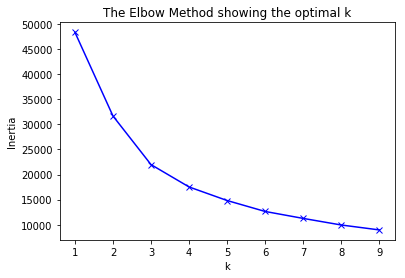

In [13]:
plot_inertia_curve(pcafeatures_train)

/Users/hdeva/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


AttributeError: module 'matplotlib.pyplot' has no attribute 'zlabel'

<Figure size 1152x864 with 0 Axes>

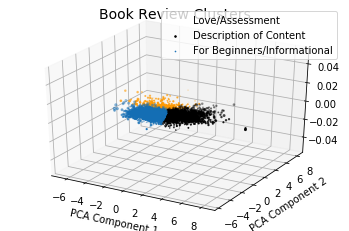

In [25]:
plt.figure(figsize=(16,12))
num_clusters = 3
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=1) # n_init, number of times the K-mean algorithm will run
km.fit(pcafeatures_train)
display_cluster_3d(pcafeatures_train,km,num_clusters,'Book Review Clusters', ['Love/Assessment', 'Description of Content', 'For Beginners/Informational'])
#plt.savefig('Book_Review_Categories.png', transparent=True)

In [1]:
from sklearn.manifold import TSNE
X_keywords = books_review_2005_df[[
       'Religion', 'Love', 'Child/Young Adult', 'Cooking', 'Recommend',
       'Life and Death', 'Good Storytelling', 'American History', 'Reference',
       'Relationships', 'Series', 'School Setting', 'Informational',
       'Easy to Follow', 'Education', 'Travel', 'Society', 'Excellent',
       'Enjoy', 'Empowerment', 'Waste of Money', 'Family', 'Game',
       'Scene Setting Family Referrals', 'Language', 'Weight Loss', 'Art',
       'Business', 'Step by Step', 'Interesting and Informative']]

scaler = StandardScaler()
X_scaled_keywords = scaler.fit_transform(X_keywords)

tsne_results = TSNE(n_components=2).fit_transform(X_scaled_keywords)

df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

cols = ['Religion', 'Love', 'Child/Young Adult', 'Cooking', 'Recommend',
       'Life and Death', 'Good Storytelling', 'American History', 'Reference',
       'Relationships', 'Series', 'School Setting', 'Informational',
       'Easy to Follow', 'Education', 'Travel', 'Society', 'Excellent',
       'Enjoy', 'Empowerment', 'Waste of Money', 'Family', 'Game',
       'Scene Setting Family Referrals', 'Language', 'Weight Loss', 'Art',
       'Business', 'Step by Step', 'Interesting and Informative']
df_subset['Topic'] = books_review_2005_clusters_df[cols].idxmax(axis=1)


plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='Topic',
    palette=sns.color_palette("hls", 30),
    data=df_subset,
    legend="full",
    alpha=0.3
)

NameError: name 'books_review_2005_df' is not defined

In [15]:
pca = PCA(n_components=2)
X_keywords = books_review_2005_df[[
       'keywords_length', 'Religion', 'Love', 'Child/Young Adult', 'Cooking', 'Recommend',
       'Life and Death', 'Good Storytelling', 'American History', 'Reference',
       'Relationships', 'Series', 'School Setting', 'Informational',
       'Easy to Follow', 'Education', 'Travel', 'Society', 'Excellent',
       'Enjoy', 'Empowerment', 'Waste of Money', 'Family', 'Game',
       'Scene Setting Family Referrals', 'Language', 'Weight Loss', 'Art',
       'Business', 'Step by Step', 'Interesting and Informative']]

scaler = StandardScaler()
X_scaled_keywords = scaler.fit_transform(X_keywords)

pcafeatures_keywords = pca.fit_transform(X_scaled_keywords)
pcafeatures_keywords

/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[ 0.206048  , -0.58219299],
       [ 1.85909874, -0.69668301],
       [ 0.22657614, -0.76647695],
       ...,
       [-0.85947291,  0.35887815],
       [ 2.74356515,  3.43216121],
       [-3.93401129,  1.6399378 ]])

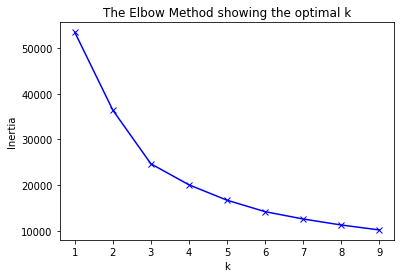

In [16]:
plot_inertia_curve(pcafeatures_keywords)

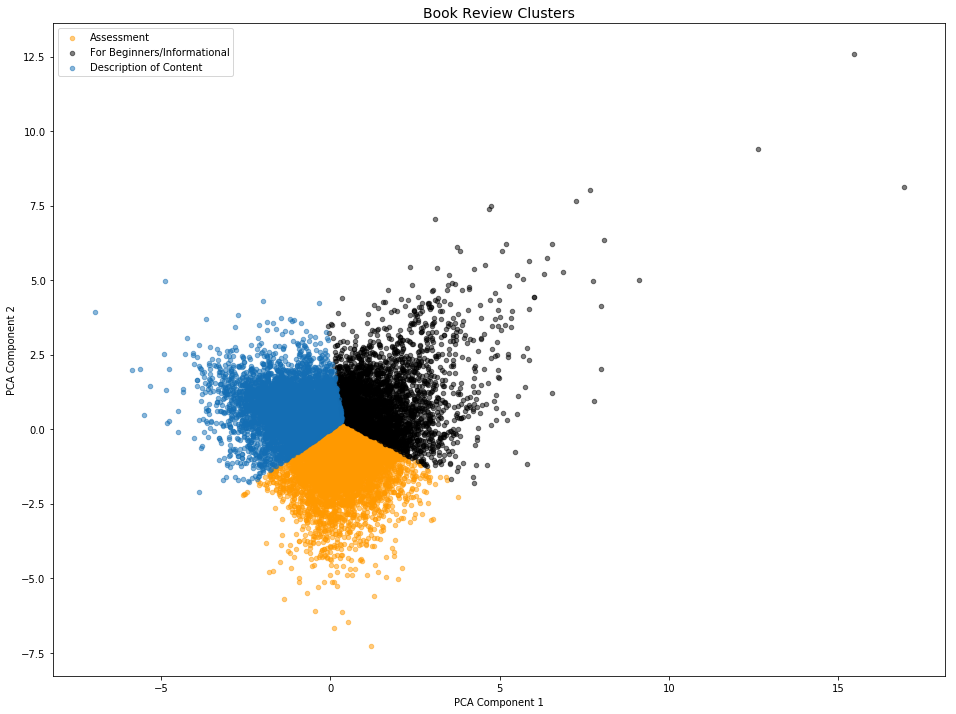

In [17]:
plt.figure(figsize=(16,12))
num_clusters = 3
km_keywords = KMeans(n_clusters=num_clusters,random_state=10,n_init=1) # n_init, number of times the K-mean algorithm will run
km_keywords.fit(pcafeatures_keywords)
display_cluster(pcafeatures_keywords,km_keywords,num_clusters,'Book Review Clusters', ['Assessment', 'For Beginners/Informational', 'Description of Content'])
plt.savefig('Book_Review_Categories_Keywords.png', transparent=True)

/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


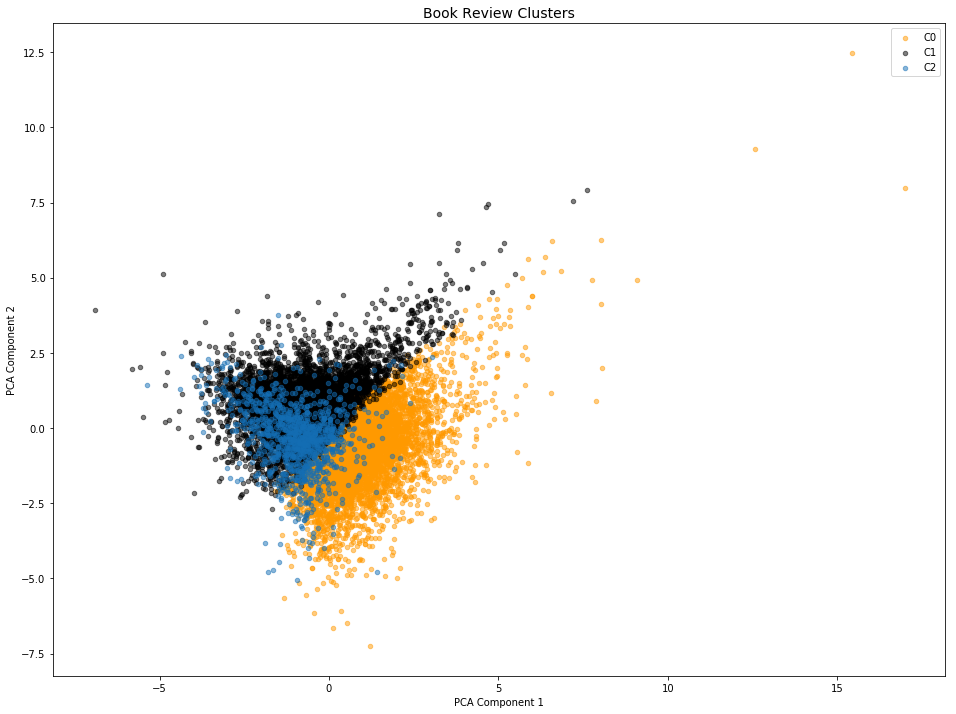

In [18]:
X_keywords = books_review_2005_df[[
       'keywords_length', 'Religion', 'Love', 'Child/Young Adult', 'Cooking', 'Recommend',
       'Life and Death', 'Good Storytelling', 'American History', 'Reference',
       'Relationships', 'Series', 'School Setting', 'Informational',
       'Easy to Follow', 'Education', 'Travel', 'Society', 'Excellent',
       'Enjoy', 'Empowerment', 'Waste of Money', 'Family', 'Game',
       'Scene Setting Family Referrals', 'Language', 'Weight Loss', 'Art',
       'Business', 'Step by Step', 'Interesting and Informative']]

scaler = StandardScaler()
X_scaled_keywords = scaler.fit_transform(X_keywords)

plt.figure(figsize=(16,12))
num_clusters = 3
km_keywords = KMeans(n_clusters=num_clusters,random_state=10,n_init=1) # n_init, number of times the K-mean algorithm will run
km_keywords.fit(X_scaled_keywords)

pca = PCA(n_components=2)

pcafeatures_keywords = pca.fit_transform(X_scaled_keywords)
pcafeatures_keywords


display_cluster(pcafeatures_keywords,km_keywords,num_clusters,'Book Review Clusters', ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6'])
plt.savefig('Book_Review_Categories_Keywords.png', transparent=True)

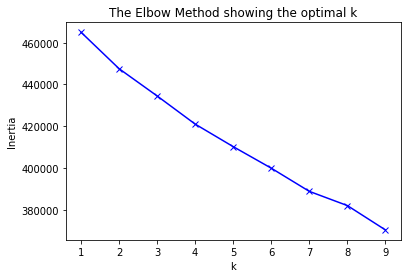

In [19]:
plot_inertia_curve(X_scaled_keywords)

In [20]:
clusters_df = pd.DataFrame(km_keywords.labels_)
books_review_2005_clusters_df = books_review_2005_df
books_review_2005_clusters_df['Clusters'] = clusters_df[0]


cols = ['Religion', 'Love', 'Child/Young Adult', 'Cooking', 'Recommend',
       'Life and Death', 'Good Storytelling', 'American History', 'Reference',
       'Relationships', 'Series', 'School Setting', 'Informational',
       'Easy to Follow', 'Education', 'Travel', 'Society', 'Excellent',
       'Enjoy', 'Empowerment', 'Waste of Money', 'Family', 'Game',
       'Scene Setting Family Referrals', 'Language', 'Weight Loss', 'Art',
       'Business', 'Step by Step', 'Interesting and Informative']
books_review_2005_clusters_df['Topic'] = books_review_2005_clusters_df[cols].idxmax(axis=1)

df = pd.DataFrame(books_review_2005_clusters_df.groupby(['Clusters','Topic']).size())

In [21]:
df.loc[df.index.get_level_values('Clusters') == 0].sort_values(by=0, ascending=False)

0
Clusters Topic                               
0        Life and Death                  1969
         Good Storytelling                739
         Love                             577
         Family                           416
         Series                           393
         Scene Setting Family Referrals   375
         Society                          366
         Relationships                    352
         Enjoy                            329
         Interesting and Informative      253
         Child/Young Adult                157
         Game                             124
         American History                 103
         Recommend                        101
         Business                          54
         Language                          49
         Waste of Money                    44
         School Setting                    43
         Art                               41
         Education                         41
         Weight Loss                       39
         Excellent                         35
         Travel                            35
         Religion                          34
         Empowerment                       31
         Step by Step                      30
         Easy to Follow                    23
         Cooking                           22
         Reference                          6
         Informational                      5

In [22]:
df.loc[df.index.get_level_values('Clusters') == 1].sort_values(by=0, ascending=False)

0
Clusters Topic                              
1        Reference                       611
         Business                        493
         Religion                        432
         Excellent                       398
         Recommend                       391
         School Setting                  369
         Easy to Follow                  361
         Travel                          357
         Informational                   350
         Language                        343
         Interesting and Informative     321
         American History                308
         Weight Loss                     294
         Waste of Money                  270
         Cooking                         251
         Life and Death                  246
         Game                            242
         Education                       229
         Society                         127
         Step by Step                     90
         Family                           82
         Art                              78
         Enjoy                            76
         Love                             64
         Child/Young Adult                61
         Scene Setting Family Referrals   60
         Relationships                    57
         Empowerment                      50
         Series                           37
         Good Storytelling                23

In [23]:
df.loc[df.index.get_level_values('Clusters') == 2].sort_values(by=0, ascending=False)

0
Clusters Topic                              
2        Art                             602
         Step by Step                    140
         Love                             57
         Cooking                          34
         Scene Setting Family Referrals   32
         Interesting and Informative      29
         Recommend                        28
         Easy to Follow                   27
         Travel                           21
         Excellent                        18
         Reference                        17
         Child/Young Adult                15
         Family                           14
         Game                             13
         Enjoy                            13
         American History                 12
         Series                           12
         Informational                    12
         Waste of Money                    9
         School Setting                    9
         Language                          7
         Good Storytelling                 7
         Society                           5
         Relationships                     4
         Education                         2
         Weight Loss                       2
         Life and Death                    1
         Business                          1

In [24]:
books_review_2005_clusters_df['Clusters'].value_counts()

1    7071
0    6786
2    1143
Name: Clusters, dtype: int64

In [25]:
books_review_2005_clusters_df.loc[books_review_2005_clusters_df['keywords_length']>2000]

,_id,product_title,review_body,review_date,review_headline,sentiment,star_rating,votes_ratio,year,keywords,...,Game,Scene Setting Family Referrals,Language,Weight Loss,Art,Business,Step by Step,Interesting and Informative,Clusters,Topic
3597,5d4ca786c986ed4ecbd7f846,The Goal: A Process of Ongoing Improvement,"The Goal, by Eliyahu M. Goldratt, is an intell...",2005-10-11,"The Goal: A ""Must Read"" Business Book",positive,5,0.655172,2005,"[intelligent, metaphoric, business, introduce,...",...,0.003,0.002,0.006,0.007,0.002,0.054,0.037,0.0,0,Business
11543,5d4ca787c986ed4ecbd82b4a,Soviet Women: Walking the Tightrope,"The Observer, December 8 1991 <br /> <br />Tho...",2005-10-03,book reviews,positive,5,1.000000,2005,"[interview, hold, ago, fascinating, pro, peres...",...,0.000,0.001,0.001,0.010,0.000,0.003,0.000,0.0,0,Relationships


In [26]:
books_review_2005_clusters_df.loc[books_review_2005_clusters_df['keywords_length']<5]

,_id,product_title,review_body,review_date,review_headline,sentiment,star_rating,votes_ratio,year,keywords,...,Game,Scene Setting Family Referrals,Language,Weight Loss,Art,Business,Step by Step,Interesting and Informative,Clusters,Topic
61,5d4ca786c986ed4ecbd7e20e,Little Pilgrim's Progress: From John Bunyan's ...,One of my favorite books. A book that adults ...,2005-10-14,A great book,positive,5,0.714286,2005,"[favorite, adult, enjoy, kid]",...,0.000,0.039,0.000,0.000,0.000,0.000,0.000,0.000,0,Enjoy
505,5d4ca786c986ed4ecbd7e4c8,Psychotherapy and the Treatment of Cancer Pati...,I'm 15 and i still found this book very intere...,2005-10-13,Great Insight,positive,5,1.000000,2005,"[interesting, idea, forward]",...,0.000,0.000,0.000,0.000,0.000,0.005,0.003,0.160,1,Interesting and Informative
517,5d4ca786c986ed4ecbd7e4e1,Leonardo da Vinci: Complete Paintings and Draw...,This is an excelent book which shoud be in any...,2005-10-13,excelent,positive,5,0.800000,2005,"[library, art, lover]",...,0.000,0.000,0.000,0.000,0.091,0.000,0.000,0.000,2,Art
552,5d4ca786c986ed4ecbd7e523,The Godfather of Grappling,"Great book, if you like Gene Lebelle and what ...",2005-10-13,The Godfather of grappling,positive,5,0.555556,2005,"[grapple, sport, easy, reading]",...,0.005,0.000,0.000,0.000,0.000,0.000,0.000,0.009,1,Easy to Follow
617,5d4ca786c986ed4ecbd7e589,The Imagineering Field Guide to Magic Kingdom ...,For anyone who loves Disney and the Disney Par...,2005-10-13,W,positive,5,0.500000,2005,"[love, able, Disney]",...,0.000,0.000,0.001,0.001,0.000,0.001,0.000,0.000,0,Love
945,5d4ca786c986ed4ecbd7e786,The Big Book of Casseroles: 250 Recipes for Se...,So many yummy casseroles. We LOVE this cookboo...,2005-10-13,Awesome!!!,positive,5,0.625000,2005,"[yummy, casserole, love, cookbook]",...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,Cooking
961,5d4ca786c986ed4ecbd7e79c,Through Death to Life: Preparing to Celebrate ...,An insigntful book which will support anyone i...,2005-10-13,Wonderful Book!,positive,5,1.000000,2005,"[wonderful, support, interested, the Ministry ...",...,0.000,0.000,0.000,0.000,0.027,0.000,0.000,0.003,2,Art
962,5d4ca786c986ed4ecbd7e79d,1: Caballo de Troya: Jerusalen (Spanish Edition),"Lei Caballo de Troya hace muchos aos, y me im...",2005-10-13,"Es el mejor audiolibro que he escuchado, parec...",positive,5,1.000000,2005,"[cobra, dado, para, Pasion de Cristo]",...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,Religion
976,5d4ca786c986ed4ecbd7e7b3,Head First Servlets and JSP: Passing the Sun C...,There are already so many good reviews about t...,2005-10-13,Fantastic,positive,5,0.714286,2005,"[fantastic, beautifully, stop, regret]",...,0.000,0.000,0.000,0.002,0.009,0.000,0.001,0.000,0,Art
978,5d4ca786c986ed4ecbd7e7b5,"Uncle Eric Talks About Personal, Career, and F...",Best Book I've ever read on Economics. Should ...,2005-10-13,Uncle Eric,positive,5,0.833333,2005,"[school, system, Economics]",...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,School Setting


In [27]:
books_review_2005_clusters_df.loc[(books_review_2005_clusters_df['Clusters'] == 0)]['keywords_length'].mean()

75.67388741526672

In [28]:
books_review_2005_clusters_df.loc[(books_review_2005_clusters_df['Clusters'] == 1)]['keywords_length'].mean()

50.154433602036484

In [29]:
books_review_2005_clusters_df.loc[(books_review_2005_clusters_df['Clusters'] == 2)]['keywords_length'].mean()

45.60542432195975

Cluster 2 has short reviews on average. This may indicate some trend in low quality reviews.

In [30]:
books_review_2005_clusters_df['Topic'].unique()

array(['Family', 'Life and Death', 'Interesting and Informative', 'Enjoy',
       'Travel', 'School Setting', 'Business', 'Series', 'Language',
       'Good Storytelling', 'Education', 'Love', 'Society', 'Reference',
       'Easy to Follow', 'Religion', 'American History', 'Art', 'Cooking',
       'Relationships', 'Informational', 'Excellent', 'Recommend',
       'Empowerment', 'Scene Setting Family Referrals', 'Waste of Money',
       'Game', 'Child/Young Adult', 'Weight Loss', 'Step by Step'],
      dtype=object)

In [31]:
books_review_2005_clusters_df.loc[(books_review_2005_clusters_df['Clusters'] == 2)][['product_title', 'keywords_length', 'Clusters', 'Topic']]

,product_title,keywords_length,Clusters,Topic
38,Tales from Slavic Myths,17,2,Art
46,Fortissimo: Backstage at the Opera with Sacred...,68,2,Art
59,The Fourteen Bears in Summer and Winter (Delux...,22,2,Excellent
69,Dick and Jane Play School,23,2,Series
72,New Knits on the Block: A Guide to Knitting Wh...,16,2,Scene Setting Family Referrals
77,The Power and The Glory The Knitting Experienc...,59,2,Art
91,Training Your Labrador Retriever (Training You...,51,2,Art
115,A Tree Grows in Brooklyn (Perennial Classics),14,2,Family
126,Putting the Heart in Your Home: Decorating Tha...,9,2,Art
129,The Whimsical Bakehouse: Fun-to-Make Cakes Tha...,112,2,Cooking


In [32]:
books_review_2005_clusters_df.iloc[14871]['review_body']

"I've given away several dozen copies of this book as gifts to friends who visit New York (including their teenage children), English teachers both American and foreign, and to new, literary friends who find it a fascinating introduction to the city I've lived in for over 25 years. It offers a comprehensive array of top-drawer writers in a focused, thematic collection. And the Everyman edition is beautiful--small and elegant with a gold ribbon bookmark. If you like NYC, or have an interest in cities and the writers who have lived in them, check this out."

In [33]:
books_review_2005_clusters_df.iloc[14996]['review_body']

"I never worked with DNN before, so i needed a simple explanation on how to perform a basic installation and more importantly how to customize it so it matches my client design & functionality. I tried to read this book, especially the chapters about skinning and creating custom modules. I stopped reading early, because it was so badly written (yes, i write bad too, but you do not see me publish a book); no step for step explanations, no real world examples in the skinning chapter and most pages are just lists of API calls and other reference steps. I should have been warned by the introduction of mr. Walker: pages and pages of text about the history of DNN that screams for some professional editing: no headers, no pictures and the text could be reduced in half without any loss in information.  <br /> <br />To summarize: this is not a step by step explanation of professional customizing DNN, it's just a badly written reference manual. DNN deserves better."

In [34]:
books_review_2005_clusters_df.iloc[14846]['review_body']

"I do love the creme de la creme cars from the 30's for their unique style and presence, and I had not found a book that came close to doing them justice till this one. There is not much detailed information on the models, just a short narative in the back, but the aesthetics of the pictures is almost overwhelming and for me obviated the need for more statistics. The cars are segmented by country, and it is fun to look at the differences in the underlying styles (and true to stereotype the French are clearly the most outrageous). There are some great, great cars in here (from the impressive Mercedes 500K to the fabulous Bugatti Atlantic) and I must say I fell in love with the Scarab pictured on the cover (kind of an elite VW van that would clearly not make it out of a design shop today!).  It would be hard to make the selected autos look anything but terrific, but Furman's sensual photo's magnify the impact and luster of each model.  The close ups of selected fittings, while not quite 

Even though they are from cluster 2, some of these reviews are of high quality. Clustering didn't do a good job finding out which reviews are of low quality.

In [39]:
books_review_2005_clusters_df.loc[(books_review_2005_clusters_df['keywords_length'] <= 15) & (books_review_2005_clusters_df['Clusters'] == 2) & (books_review_2005_clusters_df['Topic'].isin(['Love','Hate','Excellent','Enjoy', 'Recommend', 'Referrel Nouns', 'Good Storytelling']))][['product_title', 'keywords_length', 'Clusters', 'Topic']]

,product_title,keywords_length,Clusters,Topic
388,The Practical Geologist: The Introductory Guid...,12,2,Recommend
640,Night Light: A Devotional for Couples,8,2,Recommend
648,Universe: The Definitive Visual Guide,14,2,Love
733,The Chronicles of Narnia,11,2,Love
1279,"The Greatest Game Ever Played: Harry Vardon, F...",7,2,Enjoy
1736,"Yellow, Volume 1",8,2,Enjoy
1840,. . . And Baby Makes Two: A Novel,13,2,Love
1917,And Tango Makes Three,15,2,Excellent
2203,The Subject Tonight Is Love: 60 Wild and Sweet...,7,2,Love
2275,Every Woman for Herself,12,2,Good Storytelling


## Low Quality Reviews

Specifying keyword length <= 15 results in more low quality reviews. They are found in either cluster 1 or 2. 

In [41]:
books_review_2005_clusters_df.iloc[388]['review_body']

'Dougal Dixon has written a wonderful book with detailed  <br />discriptions suited for both the beginner and those already into Geology.This book is a perfect learning tool for all ages. <br />Perfect for education as well as recreational activilties. <br />I highly recommmend this intellegent,entertaining and well  <br />written book.'

Informational review. Appropriate.

In [42]:
books_review_2005_clusters_df.iloc[640]['review_body']

"A counsellor had recommended this devotional to my husband and I.  While we don't read it together every night, when we do, we really like it.  It helps get us talking about things that we may not otherwise dicuss.  It has helped bring us closer together and to God."

Scene setting. Indicator of low quality.

In [43]:
books_review_2005_clusters_df.iloc[733]['review_body']

"I read these when I was child, and I loved them then.  I still love them now.  The allegory in these books is powerful, and the story is exciting and beautiful.  This collection is a must for every family's library, to be read and re-read for generations to come."

Scene setting. Indicator of low quality.

In [44]:
books_review_2005_clusters_df.iloc[1279]['review_body']

'You don\'t have to like horses or horse-racing to enjoy this book.  Like \\\\"Seabiscuit\\\\" it is also a picture of the times.  It\'s a golf book with a great story ... and more.'

Not much information. Indicator of low quality.

In [36]:
books_review_2005_clusters_df.iloc[347]['review_body']

'I actually bought this book before I even had kids.  Now that I have a son, every October we read it every day to celebrate the month of Halloween.  I even bought the plush Spookley.  This book is one of my favorites.'

In [37]:
books_review_2005_clusters_df.iloc[432]['review_body']

"This has been the first book that has received 'read it again and then again and then again in the same day' award in our house.  Clever inventive presentation of the alphabet.  Even Granny stumbled over a couple of the 'Acts'.  Well done, author Van Allsburg."

In [38]:
books_review_2005_clusters_df.iloc[14422]['review_body']

"I read through this book in no time flat, it's was wonderful, a keeper."

In [39]:
books_review_2005_clusters_df.iloc[11384]['review_body']

'I really enjoyed this book. I even re-read a few chapters just to get that \\\\"high\\\\" feeling again.'

In [40]:
books_review_2005_clusters_df.iloc[14814]['review_body']

'These are great stories Lillian Jackson Braun does a wonderful job of  writing. I hope to one day have all the Audio Tapes in the series. Amazon.com is a great company to do bussiness with.'

In [41]:
books_review_2005_clusters_df.iloc[4291]['review_body']

'This book was for my 12-yo daughter that I bought through the \\\\"others also bought these titles...\\\\". My daughter loved it!'

In [42]:
books_review_2005_clusters_df.iloc[14942]['review_body']

"A wonderful resource to use for Children's Liturgy of the Word or for catechesis."

In [43]:
books_review_2005_clusters_df.iloc[1243]['review_body']

'This was a very enjoyable book.  Light, but interesting reading.  I even bought an extra as a gift.'

In [44]:
books_review_2005_clusters_df.iloc[4560]['review_body']

'This book had my eyes glued from the first page to the last. <br />I loved it!!'

In [45]:
books_review_2005_clusters_df.iloc[733]['review_body']

"I read these when I was child, and I loved them then.  I still love them now.  The allegory in these books is powerful, and the story is exciting and beautiful.  This collection is a must for every family's library, to be read and re-read for generations to come."

In [46]:
books_review_2005_clusters_df.iloc[1483]['review_body']

'My son loves elmo.  He has many books but his favorites are elmo books.  This is another great elmo book.'

Because this is an elmo book, this review is appropriate. Cluster had a hard time distinguishing it.

In [47]:
books_review_2005_clusters_df.iloc[14144]['review_body']

"I didn't like it.  I thought it would have pictures of poses, but most of it was reading. Things I already knew.  I'am not a porfessional at all."

In [48]:
books_review_2005_clusters_df.iloc[179]['review_body']

'i love this book.  it has crawled into my heart.  tender, loving stories of real life and finding peace in the very midst of all life is.  john tarrant writes with grace and beauty and humor.  thank you!!!'

In [49]:
books_review_2005_clusters_df.iloc[1566]['review_body']

'This book is enlightening and a really enjoyable read.....no matter what your potiltics!  Ms. Estrich is a national treasure herself!!!'

In [50]:
books_review_2005_clusters_df.iloc[13684]['review_body']

"Single Woman of a Certain Age is one of the most entertaining books I've read in a long time. Read it if you want to laugh out loud."

In [51]:
books_review_2005_clusters_df.iloc[796]['review_body']

'I loved it...but then I have been cooking with Betty Crocker for years....I really loved how they have up to date recipes and things to do....'

In [52]:
books_review_2005_clusters_df.iloc[5604]['review_body']

'This was an excellent book, especially for first time author.  I really enjoyed reading it.  Will get second book from this author.'

In [53]:
books_review_2005_clusters_df.iloc[14278]['review_body']

"I've read this book twice and it makes me want to go back to Key West twice as badly.  Great color and vivid characters.   A good read"

In [54]:
books_review_2005_clusters_df.iloc[14981]['review_body']

'Ezra Bayda\'s latest book even tells you how to use it!  He says, \\\\"Don\'t consume this book.\\\\"  I, therefore, did not read it straight through and, instead, gave it preferred space on the passenger seat of my car for those moments when I need a little encouragement.  His writing is very accessible and goes right to the heart.  Treat this book like a special friend.'

In [55]:
books_review_2005_clusters_df.iloc[14356]['review_body']

'This is a book appropriate for everyone, from leaders to families.  It changed my life.'

## Summary

It's hard to use clustering to predict whether a review is of high or low quality. Or whether it is informational, descriptive of content, or full of assessment/feelings. Clustering analysis didn't showcase any trends or differences in the reviews.

# Recommender

Ended up not using this, but code for recommender system based on reviews. 

In [253]:
H_2005.head(5)

,Religion,Love,Child/Young Adult,Cooking,Recommend,Life and Death,Good Storytelling,American History,Reference,Relationships,...,Waste of Money,Family,Game,Scene Setting Family Referrals,Language,Weight Loss,Art,Business,Step by Step,Interesting and Informative
product_title,,,,,,,,,,,,,,,,,,,,,
Sisterhood of the Traveling Pants (Book 1),0.001,0.000,0.001,0.000,0.000,0.016,0.000,0.000,0.002,0.001,...,0.002,0.026,0.000,0.014,0.019,0.001,0.0,0.001,0.001,0.000
Colby Conspiracy (Colby Agency),0.000,0.009,0.000,0.000,0.000,0.035,0.003,0.000,0.000,0.008,...,0.000,0.002,0.024,0.010,0.000,0.000,0.0,0.000,0.000,0.000
The Catcher in the Rye,0.000,0.000,0.012,0.001,0.000,0.014,0.000,0.000,0.000,0.000,...,0.004,0.004,0.000,0.015,0.002,0.000,0.0,0.000,0.000,0.055
Bait and Switch: The (Futile) Pursuit of the American Dream,0.008,0.000,0.000,0.000,0.005,0.033,0.000,0.000,0.001,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.019,0.000,0.010
A Little History of the World (Little Histories),0.000,0.000,0.000,0.003,0.000,0.000,0.000,0.035,0.003,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.004,0.001


In [293]:
from sklearn.metrics.pairwise import cosine_similarity

In [321]:
cosine_sim_matrix = cosine_similarity(H_2005)
cosine_sim_matrix.shape

(15000, 15000)

In [322]:
cosine_sim_matrix = pd.DataFrame(cosine_sim_matrix, columns=H_2005.index)

cosine_sim_matrix.index = cosine_sim_matrix.columns
cosine_sim_matrix.iloc[0:5, 0:5]

product_title,Sisterhood of the Traveling Pants (Book 1),Colby Conspiracy (Colby Agency),The Catcher in the Rye,Bait and Switch: The (Futile) Pursuit of the American Dream,A Little History of the World (Little Histories)
product_title,,,,,
Sisterhood of the Traveling Pants (Book 1),1.000000,0.418299,0.302992,0.337966,0.019657
Colby Conspiracy (Colby Agency),0.418299,1.000000,0.221037,0.619337,0.000000
The Catcher in the Rye,0.302992,0.221037,1.000000,0.404706,0.056900
Bait and Switch: The (Futile) Pursuit of the American Dream,0.337966,0.619337,0.404706,1.000000,0.048067
A Little History of the World (Little Histories),0.019657,0.000000,0.056900,0.048067,1.000000


In [282]:
cosine_sim_matrix['Sisterhood of the Traveling Pants (Book 1)'].sort_values(ascending=False)[0:5]

product_title
Sisterhood of the Traveling Pants (Book 1)     1.000000
The Only Girl in the Car: A Memoir             0.918130
Squanto: Friend of Pilgrims                    0.901528
Unforgotten (The Michelli Family Series #2)    0.900736
The Summer I Dared: A Novel                    0.894640
Name: Sisterhood of the Traveling Pants (Book 1), dtype: float64

In [283]:
cosine_sim_matrix['Seasonal Southwest Cooking: Contemporary Recipes & Menus for Every Occasion'].sort_values(ascending=False)[0:5]

product_title
Seasonal Southwest Cooking: Contemporary Recipes & Menus for Every Occasion    1.000000
The Busy Mom's Slow Cooker Cookbook                                            0.929623
Silk Road Cooking: A Vegetarian Journey                                        0.911105
The Housewives Tarot: A Domestic Divination Kit                                0.905212
Cooking Light Annual Recipes 2005                                              0.890604
Name: Seasonal Southwest Cooking: Contemporary Recipes & Menus for Every Occasion, dtype: float64

# LDA

In [156]:
from gensim import corpora
dictionary = corpora.Dictionary(books_review_2005_df['keywords'])

In [157]:
corpus = [dictionary.doc2bow(text) for text in books_review_2005_df['keywords']]

In [158]:
import gensim
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=20)

In [159]:
topics = ldamodel.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.022*"child" + 0.017*"love" + 0.009*"old" + 0.009*"feel" + 0.009*"school" + 0.009*"kid" + 0.008*"parent" + 0.008*"friend" + 0.007*"recommend" + 0.007*"give" + 0.007*"people" + 0.006*"learn" + 0.006*"tell" + 0.006*"enjoy" + 0.005*"wonderful"')
(1, '0.022*"character" + 0.015*"series" + 0.009*"enjoy" + 0.009*"interesting" + 0.008*"fan" + 0.007*"love" + 0.007*"end" + 0.006*"writing" + 0.006*"star" + 0.005*"feel" + 0.005*"movie" + 0.005*"recommend" + 0.005*"start" + 0.005*"writer" + 0.005*"finish"')
(2, '0.013*"woman" + 0.013*"man" + 0.012*"love" + 0.008*"family" + 0.007*"character" + 0.006*"people" + 0.005*"tell" + 0.005*"feel" + 0.005*"young" + 0.005*"world" + 0.005*"live" + 0.005*"leave" + 0.005*"end" + 0.005*"friend" + 0.004*"father"')
(3, '0.010*"history" + 0.006*"present" + 0.005*"world" + 0.005*"study" + 0.005*"idea" + 0.005*"point" + 0.005*"view" + 0.005*"important" + 0.005*"theory" + 0.005*"human" + 0.005*"provide" + 0.005*"subject" + 0.005*"issue" + 0.004*"people" + 0.004*"s

In [ ]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [50]:
top_5000_reviews_2005.iloc[0]

_id                                         5d4ca786c986ed4ecbd7e1a0
product_title             Sisterhood of the Traveling Pants (Book 1)
review_body        this boook was a great one that you could lear...
review_headline                this book was a great learning novel!
sentiment                                                   positive
star_rating                                                        4
votes_ratio                                                 0.666667
year                                                            2005
keywords           [learn, teach, family, value, deal, basic, iss...
Name: 0, dtype: object

In [51]:
bow = dictionary.doc2bow(top_5000_reviews_2005.iloc[0]['keywords'])
top_topics = ldamodel.get_document_topics(bow, minimum_probability=0.0)
topic_vec = [top_topics[i][1] for i in range(10)]
topic_vec

[0.001726847,
 0.02562016,
 0.0017264767,
 0.0017267346,
 0.0017272594,
 0.0017269682,
 0.44278926,
 0.0017267361,
 0.5195027,
 0.0017268064]

In [52]:
top_5000_reviews_2005.dtypes

_id                 object
product_title       object
review_body         object
review_headline     object
sentiment           object
star_rating          int64
votes_ratio        float64
year                 int64
keywords            object
dtype: object